# Siamese networks - Custom models

Siamese networks are neural networks which consist of multiple inputs and produce a single output.<br>
This notebook builds a basic Siamese network to find the similarity or dissimilarity between items of clothing using the fashion MNIST dataset

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

import numpy as np
import matplotlib.pyplot as plt
import random

## Prepare the dataset

In [2]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(f"Every number in the train images numpy array: {type(train_images[0][0][0])}")

# Prepare training and test sets
train_images = train_images.astype("float32")
test_images = test_images.astype("float32")

# Normalize
train_images = train_images / 255.0
test_images = test_images / 255.0

Every number in the train images numpy array: <class 'numpy.uint8'>


### `np.where()`

This is a powerful method for conditional selection and replacement of elements within an array. It operates similar to (if-else) statement on an element-by-element basis across an entire array which is more efficient than using Python loops.

Here `np.where(train_labels == i)` provides a tuple - ([List of indices where the training_label is i],)<br>
Hence with the loop, the list will contain - 1 list for each training label and every list will contain the indices of occurences

In [3]:
digit_indices = [np.where(train_labels == i)[0] for i in range(10)]
digit_indices

[array([    1,     2,     4, ..., 59974, 59985, 59998]),
 array([   16,    21,    38, ..., 59989, 59991, 59996]),
 array([    5,     7,    27, ..., 59977, 59981, 59993]),
 array([    3,    20,    25, ..., 59971, 59980, 59997]),
 array([   19,    22,    24, ..., 59984, 59986, 59990]),
 array([    8,     9,    12, ..., 59983, 59995, 59999]),
 array([   18,    32,    33, ..., 59973, 59987, 59988]),
 array([    6,    14,    41, ..., 59951, 59979, 59992]),
 array([   23,    35,    57, ..., 59962, 59967, 59994]),
 array([    0,    11,    15, ..., 59932, 59970, 59978])]

In [4]:
def create_pairs(x, image_indices):
    pairs = []
    labels = []
    n = min([len(image_indices[i]) for i in range(10)]) - 1

    for array_index in range(10):
        for i in range(n):
            im1, im2 = image_indices[array_index][i], image_indices[array_index][i+1]
            pairs += [[x[im1], x[im2]]]
            # Fetch a random number from [0,9] & get
            inc = random.randrange(1, 10)
            array_index_n = (array_index + inc) % 10
            im1, im2 = image_indices[array_index][i], image_indices[array_index_n][i]
            pairs += [[x[im1], x[im2]]]
            labels += [1,0]

    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    image_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, image_indices)
    y = y.astype("float32")
    return pairs, y

In [5]:
# Create pairs from training and test sets
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

### Format for the pairs list

#### Pairs
[[image1, image2], [image3, image4], ....] <br>
[label1, label2, label3, ....]

#### Labels
The labels list will always have alternating values 1 & 0 since we are creating them in that fashion in the for loop

In [6]:
# Visualize some images from the pairs
def show_image(image_pair, label):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(image_pair[0], cmap="inferno")
    ax[1].imshow(image_pair[1], cmap="inferno")
    ax[0].axis("off")
    ax[1].axis("off")
    fig.tight_layout()
    fig.suptitle(f"Label: {label}", y=0.88)
    plt.show()

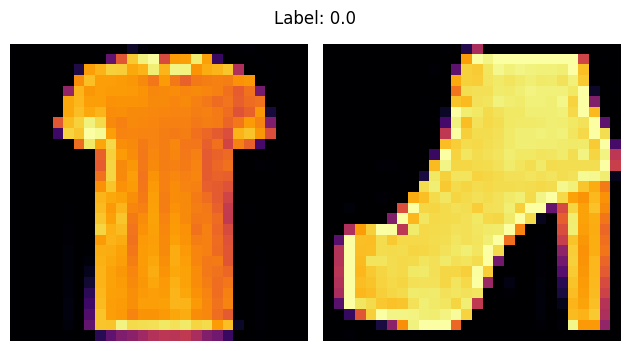

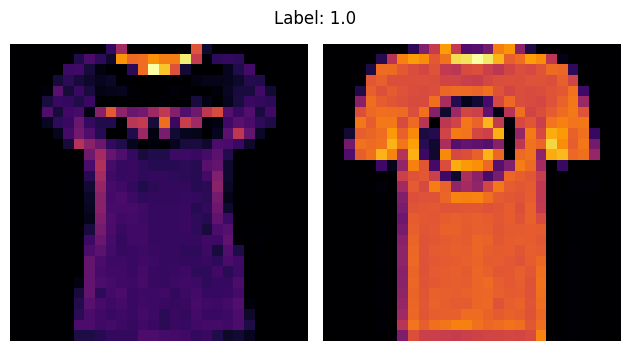

In [7]:
idx = 9
show_image(tr_pairs[idx], tr_y[idx])

idx1 = 12
show_image(tr_pairs[idx1], tr_y[idx1])

## Build the model using Functional API



In [8]:
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

def initialize_base_network():
    input = Input(shape=(28,28,), name="base_input")
    x = Flatten(name="flatten_input")(input)
    x = Dense(128, activation="relu", name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(128, activation="relu", name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation="relu", name="third_base_dense")(x)

    return Model(inputs=input, outputs=x)

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

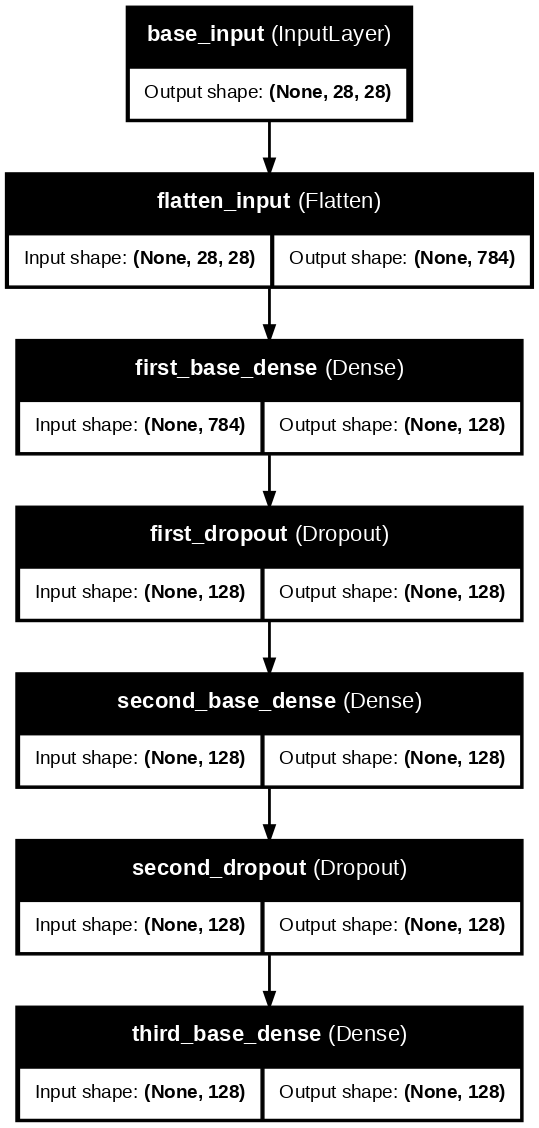

In [9]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True, dpi=100)

### Build the Siamese network

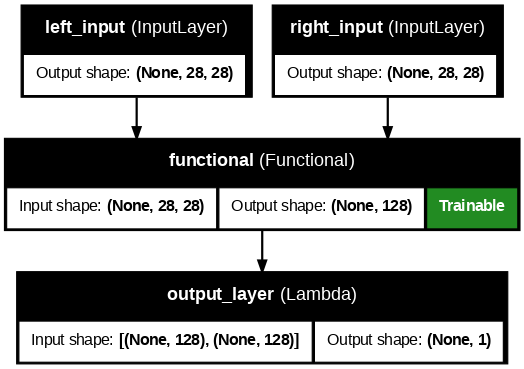

In [10]:
from tensorflow.keras.layers import Lambda

# Left side network
input_a = Input(shape=(28,28,), name="left_input")
vect_output_a = base_network(input_a)

# Right side network
input_b = Input(shape=(28,28,), name="right_input")
vect_output_b = base_network(input_b)

# Create the Euclidean distance Lambda layer
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])
model = Model([input_a, input_b], output)

plot_model(model, show_layer_names=True, show_shapes=True, show_trainable=True, dpi=80)

### Train the model

In [11]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [12]:
len(tr_pairs)

119980

In [13]:
from tensorflow.keras.optimizers import RMSprop

rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y,
                    epochs=20,
                    batch_size=128,
                    validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.1591 - val_loss: 0.0877
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0846 - val_loss: 0.0813
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0747 - val_loss: 0.0758
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0699 - val_loss: 0.0696
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0656 - val_loss: 0.0674
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0631 - val_loss: 0.0658
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0611 - val_loss: 0.0671
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0605 - val_loss: 0.0660
Epoch 9/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0573 - val_loss: 0.0690
Epoch 10/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0569 - val_loss: 0.0660
Epoch 11/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0565 - val_loss: 0.0671
Epoch 12/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

## Model Evaluation

In [14]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [15]:
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0740
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Loss = 0.06388101726770401, Train Accuracy = 0.9406567761293549 Test Accuracy = 0.9131131131131132


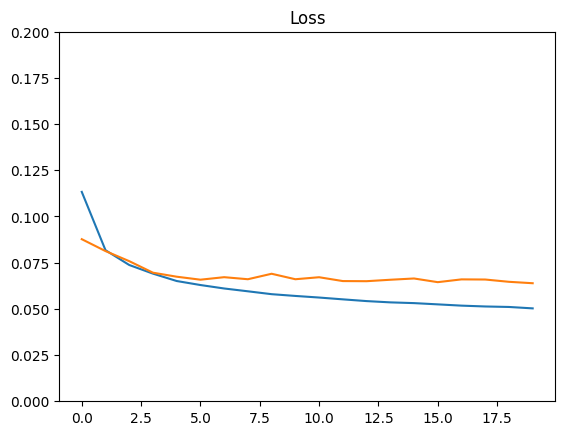

In [19]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], label=metric_name)
    plt.plot(history.history['val_' + metric_name], label='val_' + metric_name)

plot_metrics(metric_name='loss', title='Loss', ylim=0.2)

In [20]:
# Utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    # Figure1 configuration
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left, cmap="inferno")

    # Figure2 configuration
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right, cmap="inferno")



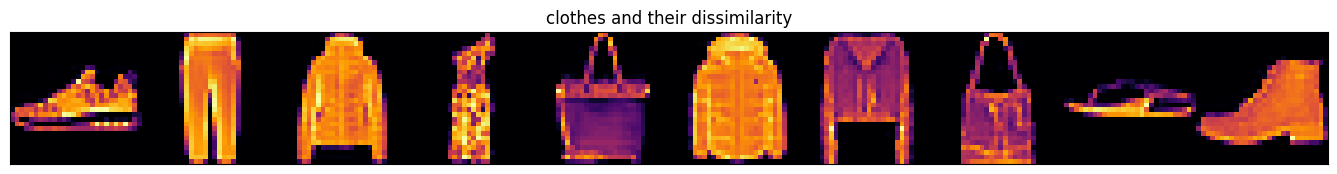

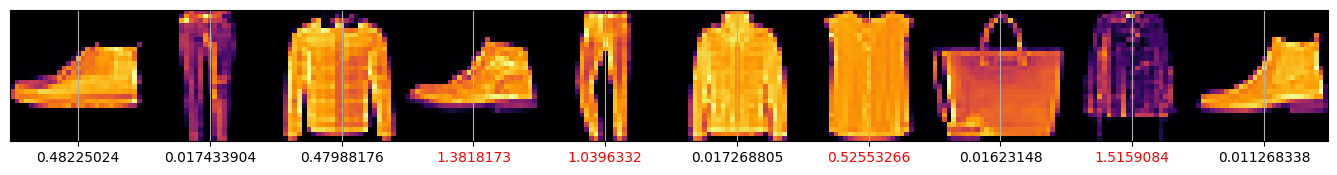

In [34]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)